In [2]:
from IPython.utils import io
import torch
import PIL
import pickle
import os
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PIL import Image
from ipywidgets import fixed

from __future__ import print_function
import argparse
import os
import random
from re import X
from cv2 import log
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
from pathlib import Path
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

from model.vae import VAE
from model.pytorch_vae import pytorch_VAE
import image_folder as ImageFolder
import log as log

import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

# MNSIT reconst

In [34]:
usedata = "MNIST"

linear_bottleneck = 1024
b = 0.001
manualSeed = 0
decode_type = 'upsamp'

data_dir = "/dataset/dataset/egg/nomal_egg"
#data_dir = '/home/taki/egg/data/egg/nomal_egg'
print(f"linear_bottleneck:{linear_bottleneck}")
#log_path = f'/home/taki/egg/log/vae/for_egg/{decode_type}_linear{linear_bottleneck}_b{b}_nomalegg_dim128_8_8'
log_path = "/home/taki/egg/log/vae/mnist/0808_mse_bottleneck1024_b1e-06"

# 再現性のためにrandom seedを設定する
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


linear_bottleneck:1024
Random Seed:  0


In [44]:
img_transform = torchvision.transforms.Compose([
                transforms.ToTensor()
])
# dataset
dataset = MNIST('./data', train = True, download=False, transform=img_transform)
train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=True)

test_dataset = MNIST('./data', train = False, download=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

############### setting ##################
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [45]:
################### test #####################
from cProfile import label

from matplotlib.pyplot import ylabel


original_imgs = []
decoded_imgs = []
diff_imgs = []

scores = []
latent_dirs = []

model_name = 'vae.pth'
model_path = os.path.join(log_path, model_name)



model = VAE(linear_bottleneck=linear_bottleneck, decode_type=decode_type)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
model.to(device)

model.eval()
with torch.no_grad():
    for batch in test_loader:

        if usedata=="egg":
            original = batch
        else:
            original, label0 = batch

        
        original = original.to(device, non_blocking=True)
        

        decoded, mu , log_var , z = model(original)
        diff = torch.abs(original - decoded)
        score = torch.mean(diff.view(diff.shape[0], -1), dim=1)
        
        original_imgs.extend(original.detach().cpu().numpy())
        decoded_imgs.extend(decoded.detach().cpu().numpy())
        diff_imgs.extend(diff.detach().cpu().numpy())

        latent_dirs.extend(z)

original_imgs = np.array(original_imgs).transpose(0, 2, 3, 1)
decoded_imgs = np.array(decoded_imgs).transpose(0, 2, 3, 1)

In [46]:
label0

tensor([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 4, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6])

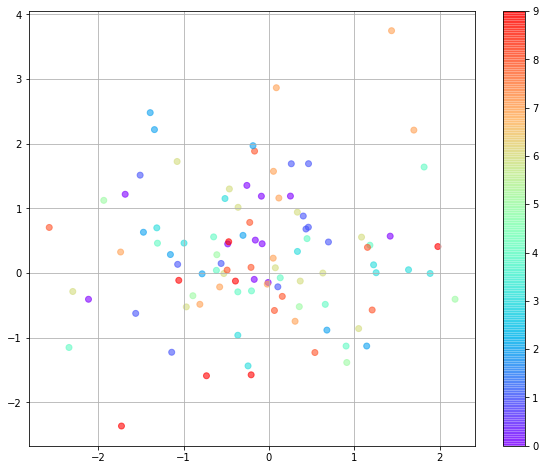

In [50]:
# z = z.detach().cpu().numpy()
# label0 = label0.detach().cpu().numpy()
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=label0, cmap="rainbow", alpha=0.6)
plt.colorbar()
plt.grid()

In [43]:
from model.vae import VAE
i=1
decoded = model.mnist_decode(latent_dirs[i])
decoded = decoded.detach().cpu().numpy()
decoded_imgs = np.array(decoded).transpose(0, 2, 3, 1)
#img = np.hstack(decoded_imgs[i])

img = np.clip((decoded_imgs[0]+1)/2, 0., 1.)
plt.imshow(img)
plt.gray()

AttributeError: 'VAE' object has no attribute 'mnist_decode'

# egg reconst

### Load model

In [6]:
num_epochs = 1000
image_size = 256
h_dim = 8*8*128
z_dim = 30
batch_size = 64
learning_rate = 1e-3
b = 5
decode_type = 'upsamp'

data_dir = "/dataset/dataset/egg/nomal_egg"
#data_dir = '/home/taki/egg/data/egg/nomal_egg'

#log_path = f'/home/taki/egg/log/vae/for_egg/{decode_type}_linear{linear_bottleneck}_b{b}_nomalegg_dim128_8_8'
#log_path = "/home/taki/egg/log/vae/for_egg/nomalegg_upsamp_linear1024_b1e-06_mse"
log_path = f'/home/taki/egg/log/vae/for_egg/1121pytorchVAE_lr{learning_rate}_inW{image_size}_b{b}_mse=sum_epoch{num_epochs}_h_dim{h_dim}_z_dim{z_dim}_batch{batch_size}_sheduler=cosin_dataaug=flip'
    

# 再現性のためにrandom seedを設定する
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  0


In [7]:
# Transform を作成する
image_size = 256
transform =     torchvision.transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((image_size, image_size)),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Dataset を作成する。
test_dataset = ImageFolder.ImageFolder(data_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False)


############### setting ##################
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
########   test  #############
model_name = 'vae.pth'
model_path = os.path.join(log_path, model_name)

model = pytorch_VAE(image_channels=3, h_dim=h_dim, z_dim=z_dim)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
model.to(device)

model.eval()
z = torch.randn(30, z_dim).to(device)
out = model.decode(z).view(-1, 3, 256, 256)
out

# model.eval()
# with torch.no_grad():
#     for i, x in enumerate(test_loader):

#         # Save the reconstructed images
#     #     x = x.to(device)
#     #     out, _, _, _ = model(x)

#     # x_concat = torch.cat([x.view(-1, 3, 256, 256), out.view(-1, 3, 256, 256)], dim=3)
#     #save_image(x_concat, os.path.join(test_path, 'test_reconst.png'))

#     # Save the sampled images
#     z = torch.randn(30, z_dim).to(device)
#     out = model.decode(z).view(-1, 3, 256, 256)
#     #save_image(out, os.path.join(test_path, 'test_sampled.png'))



tensor([[[[0.4479, 0.5843, 0.6167,  ..., 0.5503, 0.5229, 0.4756],
          [0.5865, 0.6253, 0.6574,  ..., 0.5849, 0.5518, 0.5581],
          [0.6143, 0.6314, 0.6380,  ..., 0.6053, 0.5864, 0.5868],
          ...,
          [0.4980, 0.5036, 0.5265,  ..., 0.5004, 0.5001, 0.5020],
          [0.4701, 0.4742, 0.5105,  ..., 0.5006, 0.4947, 0.4982],
          [0.4299, 0.4473, 0.4888,  ..., 0.4958, 0.4977, 0.4267]],

         [[0.4410, 0.5742, 0.6112,  ..., 0.5489, 0.5291, 0.4828],
          [0.5734, 0.6013, 0.6306,  ..., 0.5755, 0.5459, 0.5013],
          [0.5982, 0.6311, 0.6222,  ..., 0.5906, 0.5779, 0.5481],
          ...,
          [0.4635, 0.4749, 0.4991,  ..., 0.4955, 0.5106, 0.4917],
          [0.4329, 0.4479, 0.4908,  ..., 0.4980, 0.5103, 0.4774],
          [0.3833, 0.4379, 0.4805,  ..., 0.4904, 0.4880, 0.4024]],

         [[0.5677, 0.6342, 0.6782,  ..., 0.6083, 0.5715, 0.5296],
          [0.6199, 0.6560, 0.6741,  ..., 0.6149, 0.5777, 0.5489],
          [0.6572, 0.6869, 0.6706,  ..., 0

In [11]:
out[0].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


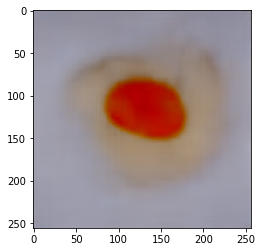

In [16]:
plt.imshow(out[2].to('cpu').detach().numpy().transpose(1, 2, 0)) 

In [16]:
latent_dirs[100]

tensor([-0.1826,  0.7137, -0.5442,  ...,  0.3065,  0.4244, -0.4030],
       device='cuda:0')

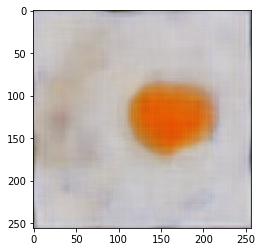

In [61]:
i=103
decoded = model.egg_decode(latent_dirs[i])
decoded = decoded.detach().cpu().numpy()
decoded_imgs = np.array(decoded).transpose(0, 2, 3, 1)
#img = np.hstack(decoded_imgs[i])

img = np.clip((decoded_imgs[0]+1)/2, 0., 1.)
plt.imshow(img)
plt.gray()

In [43]:
decoded_imgs.shape

(1, 256, 256, 3)

In [17]:
#主成分分析の実行
pca = PCA()
pca.fit(latent_dirs)
# データを主成分空間に写像
feature = pca.transform(latent_dirs)

In [32]:
len(feature)

276

In [21]:
seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d1: ', continuous_update=False, style=style)
dim1 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d2: ', continuous_update=False, style=style)
dim2 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d3: ', continuous_update=False, style=style)
dim3 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d4: ', continuous_update=False, style=style)
dim4 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d5: ', continuous_update=False, style=style)
dim5 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d6: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=10, step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=10, step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([dim0, dim1, dim2, dim3, dim4, dim5, scale, start_layer, end_layer, seed])
ui = widgets.VBox([bot_box])
display(ui)
# out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dir1': fixed(comp_dir[1]), 'dir2': fixed(comp_dir[2]), 'dir3': fixed(comp_dir[3]), 'dir4': fixed(comp_dir[4]), 'dir5': fixed(comp_dir[5]), 'dim0': dim0, 'dim1': dim1, 'dim2': dim2, 'dim3': dim3, 'dim4': dim4, 'dim5': dim5, 'scale': scale, 'start': start_layer, 'end': end_layer})

# display(out, ui)

In [24]:
pca.components_[0]

array([-0.0077659 , -0.0088842 , -0.08178303, -0.01758367,  0.07025756,
        0.07932077, -0.09217875, -0.05693468,  0.04787686,  0.08735058,
        0.0347066 , -0.00110053, -0.05335074, -0.00053943,  0.0509058 ,
        0.01058587, -0.0495655 , -0.02587789,  0.0117165 , -0.07151595,
        0.07438114,  0.04057818, -0.05841234,  0.0355718 , -0.02337929,
       -0.0802866 , -0.15745348,  0.06160261,  0.02994593,  0.03069627,
       -0.00026781,  0.06342989,  0.10760203, -0.01232996, -0.0364892 ,
        0.04334432,  0.01422807,  0.16691066, -0.01496982, -0.02173303,
       -0.07776674,  0.08322984,  0.04854014, -0.05197964, -0.05554731,
        0.02592685, -0.01282914,  0.01018954, -0.10742157, -0.03266557,
       -0.02656297,  0.07826316,  0.06352157,  0.0112694 ,  0.06935713,
       -0.15578095, -0.06539898,  0.00524764,  0.01997395,  0.00402478,
        0.099452  ,  0.01416079, -0.06153771, -0.00584498,  0.09345514,
       -0.15134679, -0.00989762,  0.1529208 ,  0.00658788, -0.03

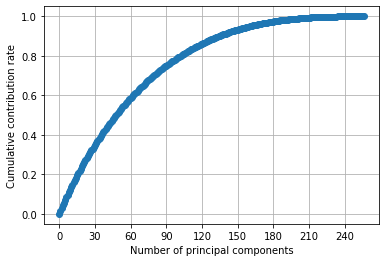

In [22]:
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

## Multiple components
### Load components

In [4]:
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []
comp_dir = []
comp_dir_stdev = []

load_activations = True

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])

num = 6

for i in range(num):
    comp_dir.append(latent_dirs[i])
    comp_dir_stdev.append(latent_stdevs[i])
    
print(f'Loaded Component No. 1~{num}')

Loaded Component No. 1~6


### Run UI

In [5]:
def display_sample_pytorch(seed, truncation, dir0, dir1, dir2, dir3, dir4, dir5, dim0, dim1, dim2, dim3, dim4, dim5, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    inv = []
    
    w = model.sample_latent(1, seed=seed).cpu().numpy()

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
        w[l] =  dir0 * dim0 * scale + dir1 * dim1 * scale + dir2 * dim2 * scale + dir3 * dim3 * scale + dir4 * dim4 * scale + dir5 * dim5 * scale
        param.append(transformer.transform(w[l]))
    
#     print(param[0][0][:num])
    
    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)

    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d1: ', continuous_update=False, style=style)
dim1 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d2: ', continuous_update=False, style=style)
dim2 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d3: ', continuous_update=False, style=style)
dim3 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d4: ', continuous_update=False, style=style)
dim4 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d5: ', continuous_update=False, style=style)
dim5 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='d6: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([dim0, dim1, dim2, dim3, dim4, dim5, scale, start_layer, end_layer, seed])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dir1': fixed(comp_dir[1]), 'dir2': fixed(comp_dir[2]), 'dir3': fixed(comp_dir[3]), 'dir4': fixed(comp_dir[4]), 'dir5': fixed(comp_dir[5]), 'dim0': dim0, 'dim1': dim1, 'dim2': dim2, 'dim3': dim3, 'dim4': dim4, 'dim5': dim5, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)

Output()

In [53]:
def display_sample_pytorch(seed, truncation, dir0, dir1, dir2, dir3, dir4, dir5, dim0, dim1, dim2, dim3, dim4, dim5, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    inv = []
    
    w = model.sample_latent(1, seed=seed).cpu().numpy()

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
        w[l] = w[l] + dir0 * dim0 * scale + dir1 * dim1 * scale + dir2 * dim2 * scale + dir3 * dim3 * scale + dir4 * dim4 * scale + dir5 * dim5 * scale
        # param.append(transformer.transform(w[l]))
        param.append(np.random.rand(1,6))
        inv.append(transformer.inverse_transform(param[l]))
        w[l][0] = inv[l][0].astype(np.float32)
        
    print(param[0][0][:num])

    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)

    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp1: ', continuous_update=False, style=style)
dim1 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp2: ', continuous_update=False, style=style)
dim2 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp3: ', continuous_update=False, style=style)
dim3 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp4: ', continuous_update=False, style=style)
dim4 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp5: ', continuous_update=False, style=style)
dim5 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Comp6: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([seed, dim0, dim1, dim2, dim3, dim4, dim5, scale, start_layer, end_layer])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dir1': fixed(comp_dir[1]), 'dir2': fixed(comp_dir[2]), 'dir3': fixed(comp_dir[3]), 'dir4': fixed(comp_dir[4]), 'dir5': fixed(comp_dir[5]), 'dim0': dim0, 'dim1': dim1, 'dim2': dim2, 'dim3': dim3, 'dim4': dim4, 'dim5': dim5, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)

Output()

## Single component
### Load a component

In [5]:
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []
comp_dir = []
comp_dir_stdev = []

load_activations = True

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
            
#load one at random 
# num = np.random.randint(20)
# if num in named_directions.values():
#   print(f'Direction already named: {list(named_directions.keys())[list(named_directions.values()).index(num)]}')

num = 10

# comp_dir = latent_dirs[num]
# comp_dir_stdev = latent_stdevs[num]

comp_dir.append(latent_dirs[num])
comp_dir_stdev.append(latent_stdevs[num])
    
print(f'Loaded Component No. {num}')


Loaded Component No. 10


### Run UI

In [7]:
def display_sample_pytorch(seed, truncation, dir0, dim0, scale, start, end, disp=True, save=None, noise_spec=None):
    # blockPrint()
    # with io.capture_output() as captured:
    param = []
    w = model.sample_latent(1, seed=seed).cpu().numpy()

    model.truncation = truncation
    w = [w]*model.get_max_latents() # one per layer
    for l in range(start, end):
      w[l] = w[l] + dir0 * dim0 * scale 
      param.append(transformer.transform(w[l]))
        
#     print(param[0][0][num])

    #save image and display
    out = model.sample_np(w)
    final_im = Image.fromarray((out * 255).astype(np.uint8)).resize((256,256),Image.LANCZOS)

    if disp:
      display(final_im)
    if save is not None:
      if disp == False:
        print(save)
      final_im.save(f'out/{seed}_{save:05}.png')


seed = np.random.randint(0,100000)
style = {'description_width': 'initial'}

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.7, description='Truncation: ', continuous_update=False)
dim0 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='SelectedComp: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=0, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=model.get_max_latents(), step=1, value=18, description='end layer: ', continuous_update=False)

# Make sure layer range is valid
def update_range_start(*args):
  end_layer.min = start_layer.value
def update_range_end(*args):
  start_layer.max = end_layer.value
start_layer.observe(update_range_start, 'value')
end_layer.observe(update_range_end, 'value')

text = widgets.Text(description="Name component here", style=style, width=200)

bot_box = widgets.VBox([seed, dim0, scale, start_layer, end_layer])
ui = widgets.VBox([bot_box])

out = widgets.interactive_output(display_sample_pytorch, {'seed': seed, 'truncation': truncation, 'dir0': fixed(comp_dir[0]), 'dim0': dim0, 'scale': scale, 'start': start_layer, 'end': end_layer})

display(out, ui)


Output()

# Convert w to param

In [5]:
w_test = np.load('questionnaire/w_test.npy')
print(w_test.shape)
print(w_test)
param_test = transformer.transform(w_test)
print(param_test.shape)
print(param_test)
np.save('questionnaire/param_test.npy', param_test)

(34, 512)
[[ 0.3440561  -0.950136    0.5900445  ... -0.62184376 -0.43264222
   1.2390425 ]
 [ 0.37139365 -0.6246364   0.80698174 ... -1.2422309  -1.9276294
  -0.23519118]
 [-0.09118952 -0.20676489  1.1669356  ... -0.7095085   1.6524553
   0.98981756]
 ...
 [ 0.79115605 -0.30226016 -0.20428316 ... -0.8007261   0.14960529
   0.93486595]
 [ 1.0991617  -0.961632    0.8275591  ...  0.46156552 -1.6141889
   0.42750245]
 [ 0.14710009 -1.0717025   0.20085426 ... -0.7783195   0.9358142
   0.01562361]]
